In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
grid_size = 50
num_a = 4
num_states = grid_size ** 2

min_A = 0.4 * 4.5
A_penalty = -3

min_B = 0.15 * 4.5
B_penalty = -3

max_D = 0.1 * 4.5

'''

(2 x 8 x 8 x 3) matrix

[0, ...] is estimated production
[1, ...] is production speed

[:, x, y, :] is state (x, y)

[..., 0] = values for A
[..., 1] = values for B
[..., 2] = values for C

'''

s_1 = (np.random.randint(0, 10, num_a * grid_size ** 2)).reshape(1, grid_size, grid_size, num_a).astype("float64")

s_2 = np.zeros_like(s_1)

states = np.concatenate([s_2, s_1], axis=0)

In [3]:
def reset_states():
    s_1 = (np.random.randint(0, 10, num_a * grid_size ** 2)).reshape(1, grid_size, grid_size, num_a).astype("float64")
    s_2 = np.zeros_like(s_1)
    states = np.concatenate([s_2, s_1], axis=0)
    return states

In [4]:
def _Q(x, y, a, states=states):
    
    tmp_s = np.copy(states[:, x, y, :])
    
    # adds state's production of X to global estimate of X
    tmp_s[0, a] += (tmp_s[1, a] / num_states)
            
    r_a = A_penalty * max(0, min_A - tmp_s[0, 0] * num_states)
    r_b = B_penalty * max(0, min_B - tmp_s[0, 1] * num_states)
    r_c = tmp_s[0, 2]
    r_d = 5 * np.clip(tmp_s[0, 3] * num_states, 0, max_D)
    
    return sum([r_a, r_b, r_c, r_d])

In [5]:
def _pi(x, y, states):
    return np.argmax([_Q(x, y, a, states) for a in range(num_a)])

In [6]:
def greedy(x, y, states):
    return states[1, x, y].argmax()

In [7]:
# returns a matrix, actions, where actions[x, y, a] = P(A = a | S = (x, y))
def actions_matrix(states, policy=_pi, flat=False):
    
    if flat:
        actions = np.zeros((grid_size, grid_size))
        for i in range(grid_size):
            for j in range(grid_size):
                actions[i, j] = policy(i, j, states)
    
        return actions
    

    actions = np.zeros((grid_size, grid_size, num_a))

    for i in range(grid_size):
        for j in range(grid_size):
            actions[i, j, policy(i, j, states)] = 1          
            
    return actions

In [8]:
#A_penalty * (max(0, prmin_A * num_states)

def true_Reward(states, actions, verbose=False):
    
    # A matrix of the production at each state
    production = np.multiply(states[1, ...], actions)

    # prouction per A, B, C
    prod_sum = production.sum(axis=(0, 1))

    R_a = A_penalty * max(0, min_A * num_states - prod_sum[0])
    R_b = B_penalty * max(0, min_B * num_states - prod_sum[1])
    R_c = prod_sum[2]
    R_d = 5 * min(prod_sum[3], max_D * num_states)
    
    if verbose:
        print(prod_sum)
        print([R_a, R_b, R_c, R_d])
    
    return sum([R_a, R_b, R_c, R_d])

In [9]:
def neighbors(x, y, prod):
    n = idx_neighbors(x, y)

    out = []

    for i in n:
        out.append(prod[i[0], i[1]])

    return np.array(out)

In [10]:
def idx_neighbors(x, y, num=25):
    
    return np.random.randint(0, grid_size, num*2).reshape(num, 2)

In [11]:
def to_cat(val):
    tmp = np.array([0 for i in range(num_a)])
    tmp[val] = 1
    return tmp

In [12]:
def update_est(states, actions, gamma=0.25):
    
    new_est = np.zeros_like(states[0])
    new_states = np.copy(states)

    production = np.multiply(states[1, ...], actions) / num_states

    # for each state, for each action, set est to average of neighbors production in place
    for i in range(grid_size):
        for j in range(grid_size):
            prod = neighbors(i, j, production)
            for a in range(num_a):
                new_states[0, i, j, a] += gamma * (prod[..., a].mean() - new_states[0, i, j, a])
    
    return new_states

In [13]:
# state (x, y) has production speeds (j, k) for tasks A and B 
# state (x', y') has production speeds (j', k') for tasks A and B

# if state (x, y) is doing task A, and state (x', y') is doing task B
# and j' > j and k > k
# then the states trade jobs

# alternate: if (j' + k) > (j + k')

def trade_jobs(x, y, _x, _y, actions, states):
    original = _Q(x, y, actions[x, y].argmax(), states) + _Q(_x, _y, actions[_x, _y].argmax(), states)
    new = _Q(x, y, actions[_x, _y].argmax(), states) + _Q(_x, _y, actions[x, y].argmax(), states)
    
    if new > original:
        tmp = np.copy(actions[x, y])
        actions[x, y] = np.copy(actions[_x, _y])
        actions[_x, _y] = tmp
    return actions

In [14]:
def job_allocate(actions, states):
    for x in range(grid_size):
        for y in range(grid_size):
            for n in idx_neighbors(x, y):
                actions = trade_jobs(x, y, *n, actions, states)
    return actions

In [17]:
states = reset_states()

frames = []
rewards = []
expected = []

for i in range(20):
    
    actions = actions_matrix(states)
        
    #actions = job_allocate(actions, states)
    
    reward = true_Reward(states, actions)

    states = update_est(states, actions, gamma=0.1)
    
    frames.append(actions_matrix(states, flat=True))
    rewards.append(reward)

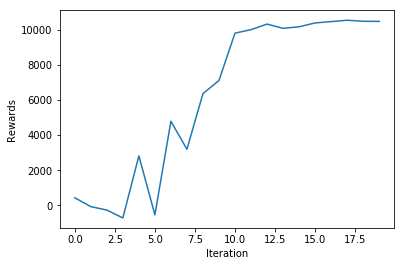

In [23]:
plt.plot(rewards)
plt.ylabel("Rewards")
plt.xlabel("Iteration")
plt.show()

In [18]:
actions = actions_matrix(states)
print(min_A * num_states, int(min_B * num_states), max_D * num_states)
true_Reward(states, actions, verbose=True)

4500.0 1687 1125.0
[4580. 2024. 4735. 1315.]
[0, 0, 4735.0, 5625.0]


10360.0

In [19]:
actions = actions_matrix(states, greedy)
true_Reward(states, actions, verbose=True)

[5833. 4893. 4203. 3763.]
[0, 0, 4203.0, 5625.0]


9828.0

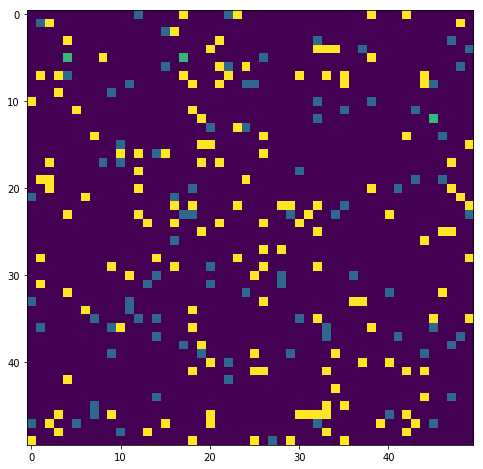

In [24]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = frames[0] / (num_a - 1)

im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

fps = 1

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(frames[i] / (num_a - 1))
    
None

In [25]:
ani = matplotlib.animation.FuncAnimation(fig, animate_func, frames=len(frames))

from IPython.display import HTML
HTML(ani.to_jshtml())

.....................